In [3]:
%matplotlib inline
import xarray as xr
import glob
import copy
import numpy as np
from datetime import datetime
import os
import sys 

# # you need intake-esm V 2020.11.4 and intake V 0.6.0

# # import tensorflow as tf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import fsspec
import cmocean
import xskillscore as xs


In [2]:
# Read Control Run
d = '/glade/scratch/acsubram/S2S_Database/IVT_20170213.nc'
dsfcst = xr.open_dataset(d)
dsfcst

<xarray.Dataset>
Dimensions:     (latitude: 121, longitude: 240, number: 50, step: 47)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 0 days 1 days 2 days ... 45 days 46 days
  * latitude    (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude   (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
    valid_time  (step) datetime64[ns] ...
Data variables:
    ivt         (number, step, latitude, longitude) float32 ...

In [3]:
ivt = dsfcst['ivt']
lat = dsfcst['latitude']
lon = dsfcst['longitude']

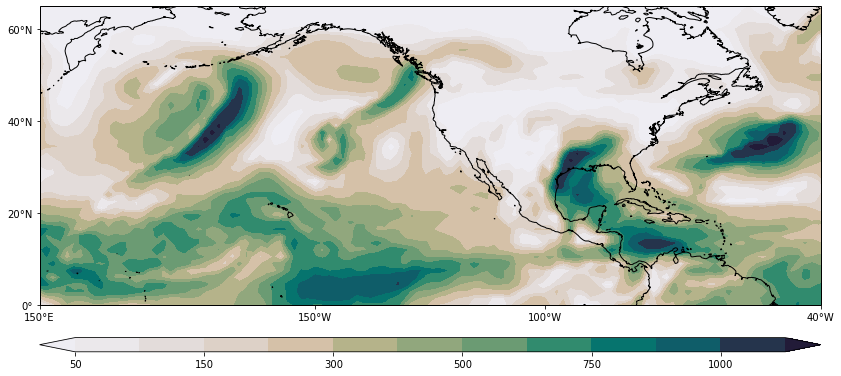

In [4]:
ivt_plt = ivt[1,30,:,:]
mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([150, 320 , 0, 65], ccrs.PlateCarree())
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
ax.set_xticks([150, 210, 260, 320], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))


# Plot IVT
clevs = [50,100,150,200,300,400,500,600,750,850,1000,1250]
cf = ax.contourf(lon, lat, ivt_plt , clevs, cmap = cmocean.cm.rain,
                 transform=datacrs, extend="both")
#cmap=plt.cm.BuPu

plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
plt.show()
# fig.savefig('AR_Track_ens1.png', bbox_inches='tight')

## Plot Spread / Skill Time Series

## Open the Obs
This needs to be regridded! 

In [5]:
IVT_obs = xr.open_mfdataset(sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/ERA5/ERA5_IVT*2*_lores.nc')),combine='by_coords')
# select only 0z to match the s2s forecast
IVT_obs = IVT_obs.isel(time=IVT_obs.groupby("time.hour").groups[0])

IVT_obs

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 182)
Coordinates:
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 85.5 87.0 88.5 90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * time     (time) datetime64[ns] 2016-12-01 2016-12-02 ... 2017-05-31
Data variables:
    IVT      (time, lat, lon) float64 dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    uIVT     (time, lat, lon) float64 dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    vIVT     (time, lat, lon) float64 dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    IWV      (time, lat, lon) float64 dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
Attributes:
    CDI:                        Climate Data Interface version 1.9.9 (https:/...
    Conventions:                CF-1/0
    history:                    Thu Jul 08 00:20:36 2021: cdo -remapcon,r240x...
    history_of_appended_files:  Tue Jul 14 13:29:00 2020: Appended file ERA5_...
    NCO:         

## Now Plot the weighted Spread

In [6]:
FilList = sorted(glob.glob('/glade/scratch/acsubram/S2S_Database/IVT*2*.nc'))

#######
# Subset for region of interest like so:
latwant=[80,15] # North-to-South
lonwant=[140,240]
#######

##################################################################
#first creat a weight matrix to scale by latitude:
##################################################################
#compute RMSE and Spread
df = xr.open_dataset(FilList[0])
weight_r = np.cos(np.deg2rad(df.latitude))
_, weight_r = xr.broadcast(df,weight_r)
weight_r  = weight_r.isel(step=0,number=0)

#initialize array's
shpp =np.array(df['ivt']).shape
compiled_forecast = np.zeros([len(FilList),shpp[0],shpp[1],shpp[2],shpp[3]])
# compiled_obs = np.zeros([len(DF_GPH['File'][-yrsback:]),shpp[1],shpp[2],shpp[3]])

for yy,dd  in enumerate(FilList):
    print(dd)
    df = xr.open_dataset(dd)
    compiled_forecast[yy,:,:,:,:] = np.array(((df['ivt'])))## - np.expand_dims(OBS_clim,axis=1))) This is where you subtract lead time bias
#     compiled_obs[yy,:,:,:,] = np.array(IVT_obs.sel(time=slice(df.time.values[0],df.time.values[1])).ivt) ##
    
leader = np.arange(0,47,1)
lat = np.array(df.latitude)
lon = np.array(df.longitude)
number = np.arange(0,50,1)
issued=np.arange(0,len(FilList),1)

##################################################################
# # compiled forecasts in Xarray's:
##################################################################

C_for = xr.Dataset(
    {
        "ivt": (["issued","ensemble","lead","latitude", "longitude"],compiled_forecast),
        
    },
    coords={
        "issued":issued,
        "lead":leader,
        "ensemble":number,
        "latitude":lat,
        "longitude":lon,
    },)

C_for.attrs["title"] = "EC S2S IVT Forecast "
# C_obs.ivt.attrs['units'] = 'kg m-1 s-1'
C_for.ivt.attrs['standard_name']='Integrated Vapor Transport'
C_for.ivt.attrs['long_name']='Integrated Vapor Transport'

# ########################################################
# #compiled obs in Xarray's:
# ########################################################
# lat = np.array(df.latitude)
# lon = np.array(df.longitude)
# C_obs = xr.Dataset(
#     {
#         "ivt": (["issued","lead","latitude", "longitude"],compiled_obs),
        
#     },
#     coords={
#         "issued":issued,
#         "lead":leader,
#         "latitude":lat,
#         "longitude":lon,
#     },)

# C_obs.attrs["title"] = "EC S2S IVT Forecast "
# C_obs.ivt.attrs['units'] = 'kg m-1 s-1'
# C_obs.ivt.attrs['standard_name']='Integrated Vapor Transport'
# C_obs.ivt.attrs['long_name']='Integrated Vapor Transport'
# ########################################################
# ########################################################

C_for_roi = C_for.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
# C_obs_roi = C_obs.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
print('...do ensemble mean...')
C_for_roi_ensemean = C_for_roi.mean('ensemble')



/glade/scratch/acsubram/S2S_Database/IVT_20170102.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170105.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170109.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170112.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170116.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170119.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170123.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170126.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170130.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170202.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170206.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170209.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170213.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170216.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170220.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170223.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170227.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170302.nc
/glade/scratch/acsubram/S2S_Database/IVT_20170

In [9]:
weight_r = weight_r.sel(latitude=slice(latwant[0],latwant[1]),longitude=slice(lonwant[0],lonwant[1]))
Spread= C_for_roi.ivt.std("ensemble").weighted(weight_r).mean(("latitude","longitude","issued")).data

AttributeError: 'DataArray' object has no attribute 'weighted'

## This is to Add Uncertainty Bounds

In [8]:
%%time
bsnummy= 100
subset_percentage = 0.75
Spread_err = np.zeros([bsnummy,Spread.shape[0]])
# RMSE_err = np.zeros([bsnummy,Spread.shape[0]])

for ii in range(bsnummy):
    if (ii % 1)==0:
        print('iteration #:',ii)
    fcs =np.random.randint(0,int((np.array(C_for.issued.max())*subset_percentage)),len(FilList))
    ctm = C_for_roi.sel(issued=fcs)
    Spread_err[ii,:] = ctm.ivt.std("ensemble").weighted(weight_r).mean(("latitude","longitude","issued")).data
    
#     cfm = C_for_roi_ensemean.sel(issued=fcs)
#     cobs = C_obs_roi.sel(issued=fcs)
    
#     RMSE_err[ii,:] = xs.rmse(cobs,cfm,dim=['issued']).ivt.weighted(weight_r).mean(("latitude","longitude")).data

NameError: name 'Spread' is not defined

## Plot Spread / Skill

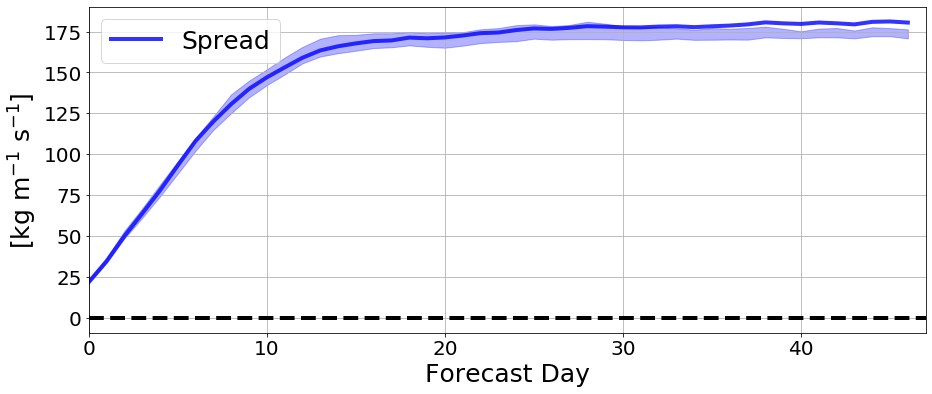

In [34]:
################################################

plt.figure(figsize=(15,6))

# plt.plot(RMSE,color='k',linewidth=4,label='RMSE')
# plt.fill_between(np.arange(0,46),np.percentile(RMSE_err,95,axis=0),np.percentile(RMSE_err,5,axis=0),alpha=0.3,color='k')

plt.plot(Spread,color='b',linewidth=4,label='Spread',alpha=0.8)
plt.fill_between(np.arange(0,47),np.percentile(Spread_err,99,axis=0),np.percentile(Spread_err,1,axis=0),alpha=0.3,color='b')

plt.plot([0,65],[0,0],color='k',linestyle='--',linewidth=4)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([0,47])
# plt.ylim([0,110])

plt.grid(True)
plt.xlabel('Forecast Day',fontsize=25)
plt.ylabel('[kg m$^{-1}$ s$^{-1}$]',fontsize=25)
plt.legend(fontsize=25)

path_to_save = "/glade/work/wchapman/ECMWF_20C/notebooks/Reproduce_Weishemer/Figures/testbad.png"
# plt.savefig(path_to_save,dpi=300,bbox_inches='tight')

plt.show()
